In [1]:
import pandas as pd
import pyodbc
import numpy as np

class get_df:

    def __init__(self):
        self.DB_infos = {"X01" : ("192.168.1.16", "X01", "cm23357868", "86875332")}
        self.querys = {}
        self.db = str()
        self.df_dict =  dict()
        self.w_code_dict = dict()
        self.point_dict = dict()
        self.result_dict = dict()
        
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        return df
    @staticmethod
    def make_ETF():
        sql_ETF_price ="""SELECT    [日期]
                        ,[股票代號]
                        ,[股票名稱]
                        ,[開盤價]
                        ,[最高價]
                        ,[最低價]
                        ,[收盤價]
                        ,[漲跌]
                        ,[漲幅(%)]
                        ,[振幅(%)]
                        ,[成交量]
                        ,[成交筆數]
                        ,[成交金額(千)]
                        ,[均張]
                        ,[成交量變動(%)]
                        ,[均張變動(%)]
                        ,[股本(百萬)]
                        ,[總市值(億)]
                        ,[週轉率(%)]
                        ,[成交值比重(%)]
                        ,[漲跌停]
                        ,[成交量(股)]
                     
                    FROM [X01].[dbo].[日收盤還原表排行] where  股票代號 like '0%' and 日期 >= '20020101' order by 日期 desc"""
        return sql_ETF_price

    @staticmethod
    def make_ETF_DP():
        sql_ETF_DP ="""SELECT    [日期]
                        ,[股票代號]
                        ,[股票名稱]
                        ,[淨值]
                        ,[淨值漲跌]
                        ,[淨值漲跌幅(%)]
                        ,[折溢價(%)]
                        ,[淨值(原幣)]
                        ,[淨值漲跌(原幣)]
                        ,[淨值漲跌幅(原幣)]
                        ,[基金淨資產價值(千)]
                        ,[已發行受益權單位總數(千)]
                        ,[與前日已發行單位差異數(千)]
                        ,[已發行受益權單位總數(含加掛ETF)(千)]
                        ,[與前日已發行單位差異數(含加掛ETF)(千)]
                        ,[RTIME]
                       
                    FROM [X01].[dbo].[ETF折溢價表] where 日期 >= 20020101 order by 日期"""
        return sql_ETF_DP

In [2]:
sql_base = get_df()
sql_base.db_connect('X01')


Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


In [3]:
sql_base.querys['日收盤還原表排行'] = sql_base.make_ETF()
ETFtable = sql_base.load_data('日收盤還原表排行')

sql_base.querys['ETF折溢價表'] = sql_base.make_ETF_DP()
dptable = sql_base.load_data('ETF折溢價表')

C:\Users\larryx30\AppData\Local\Temp\ipykernel_8416\383989772.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df =  pd.read_sql(self.querys[query], self.db)


In [4]:
data_frame = ETFtable.merge(dptable, on = ['日期','股票代號','股票名稱'], how = 'left').fillna(0)

In [5]:
ETF行情表 = data_frame
ETF行情表 = ETF行情表.sort_values(by = ['日期','股票代號']).reset_index(drop = True)
ETF行情表['日期'] = pd.to_datetime(ETF行情表['日期'],format = "%Y%m%d").fillna(0)
ETF行情表 = ETF行情表.set_index('日期')

In [6]:
ETF1 = pd.Series(ETF行情表['股票代號'])
ETFlist = ETF1.sort_values().drop_duplicates()
ETFlist = list(ETFlist)

In [7]:
from tqdm import tqdm
ETF_dict = {str(ETFlist[i]):ETF行情表[ETF行情表['股票代號'] == ETFlist[i]] for i in tqdm(range(len(ETFlist)))}

100%|██████████| 367/367 [00:05<00:00, 67.78it/s]


In [8]:
feature_ls = ETF行情表.columns[2:]
ETF行情表 = ETF行情表.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(ETF行情表.columns[2:]):
    data_pivot = ETF行情表.pivot(index='日期',columns='股票代號',values=feature)
    data_pivots_ls.append(data_pivot)

100%|██████████| 33/33 [00:02<00:00, 14.03it/s]


In [9]:
pivot_dict = {str(ETF行情表.columns[2:][i]):data_pivots_ls[i] for i in range(len(ETF行情表.columns[2:]))}

ETF_dict.update(pivot_dict)

In [10]:
responseETF = pd.read_excel(r'C:\Users\larryx30\Desktop\\股票型ETF代碼.xlsx')
responseETF['股票代號'] = '00'+responseETF['股票代號'].astype(str)
responseETF.index = responseETF.index+1
SETF = responseETF['股票代號']

In [11]:
ETFDDW = {}
for j in tqdm(ETFlist):
    ETFDDW[str(j)] = ETF_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last', '成交金額(千)':'sum','折溢價(%)':'mean'\
                                                           }).fillna(method = 'pad' ,axis = 0)

100%|██████████| 367/367 [00:01<00:00, 355.77it/s]


In [12]:
大盤夏普值 = pd.read_excel(r'\Users\larryx30\larryx30\每週買賣報表\大盤夏普值.xlsx')

In [13]:
大盤夏普值 = 大盤夏普值.set_index('日期')

In [14]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(SETF):
    
    ETFDDW[str(x)]['MAX52'] = ETFDDW[str(x)]["收盤價"].rolling(5).max()
    ETFDDW[str(x)]["MAX52S"] = ETFDDW[str(x)]["MAX52"].shift(1)
    ETFDDW[str(x)]["20MA"] = talib.MA(ETFDDW[str(x)]["收盤價"].dropna(), timeperiod=20, matype=0)
    ETFDDW[str(x)]["20MAS"] = ETFDDW[str(x)]["20MA"].shift(1)
    ETFDDW[str(x)]["5MA"] = talib.MA(ETFDDW[str(x)]["收盤價"].dropna(), timeperiod=5, matype=0)
    ETFDDW[str(x)]["5MAS"] = ETFDDW[str(x)]["5MA"].shift(1)
    
    ETFDDW[str(x)]["DR"] = ((ETFDDW[str(x)]["收盤價"] - ETFDDW[str(x)]["收盤價"].shift(1))/ETFDDW[str(x)]["收盤價"].shift(1))*100
    ETFDDW[str(x)]['SHARPE'] = 大盤夏普值['sharpe']
    
    KPBS = 0
    KPBUY =[]
    for z in range(len(ETFDDW[str(x)])):

        if ETFDDW[str(x)]["收盤價"].iloc[z]  > ETFDDW[str(x)]["MAX52S"].iloc[z] :
              
            KPBS = 4

        elif ETFDDW[str(x)]["收盤價"].iloc[z] < 0:
                  
            KPBS = 0
            
        KPBUY.append(KPBS)
    ETFDDW[str(x)]["KPBUY"] = KPBUY
    ETFDDW[str(x)]["KPBUYS"] = ETFDDW[str(x)]["KPBUY"].shift(1)
    pzb = ETFDDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = ETFDDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    ETFDDW[str(x)]["KPRR"] = ETFDDW[str(x)]["DR"] * ETFDDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = ETFDDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

#trrb =(trr).replace(np.inf,0).sort_index().sum(axis = 1).cumsum().plot(figsize=(20, 10),grid = True)


100%|██████████| 47/47 [00:00<00:00, 140.79it/s]


Text(0, 0.5, 'Profit')

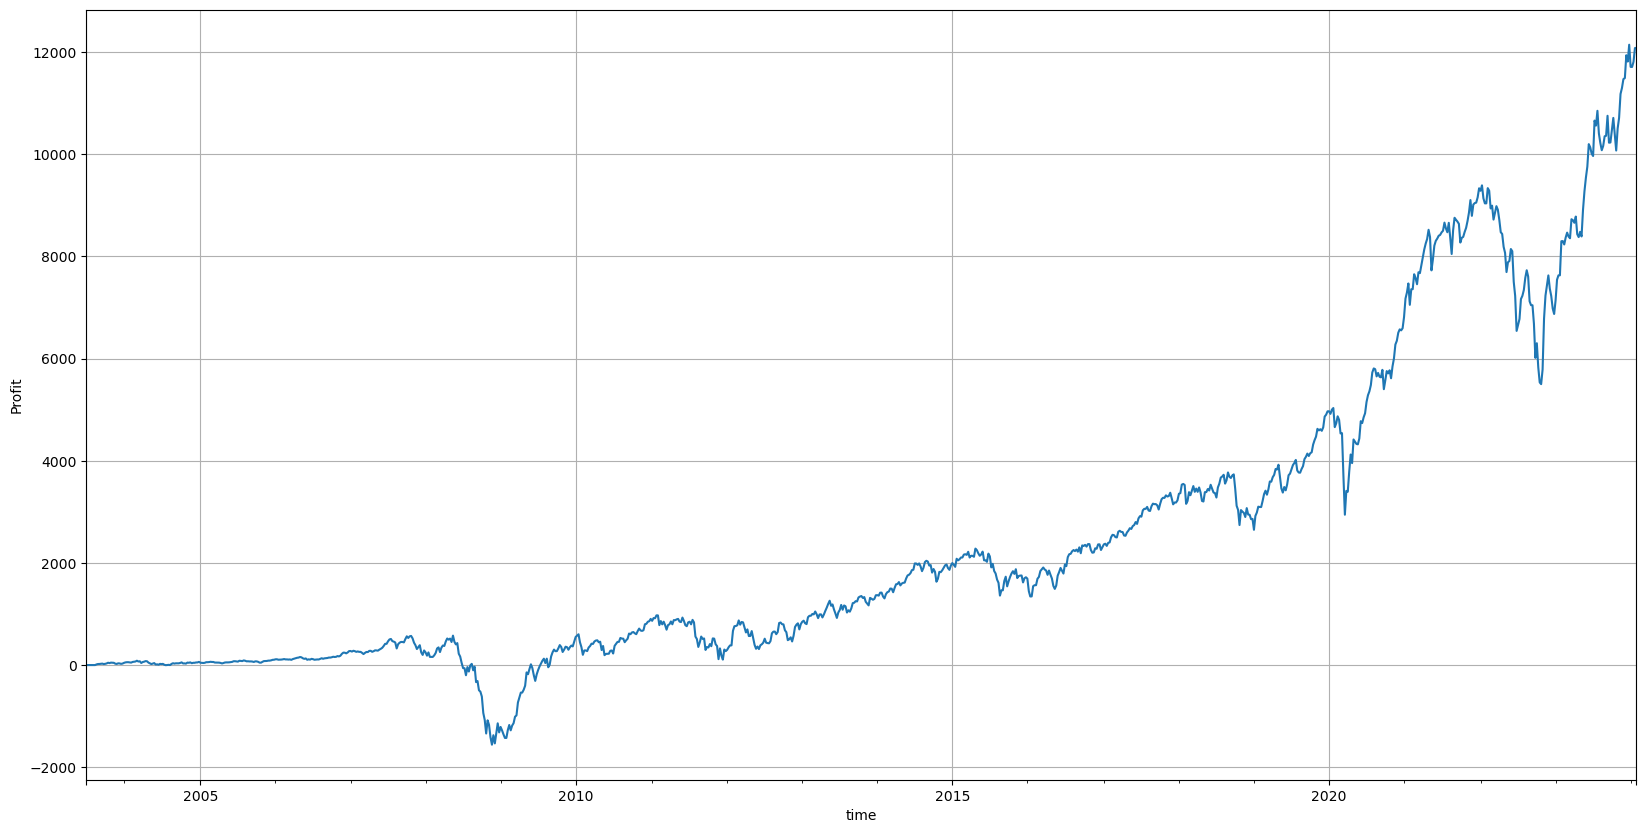

In [15]:
import matplotlib.pyplot as plt
ETF損益圖 = (trr).replace(np.inf,0).sort_index().sum(axis = 1).cumsum().plot(figsize=(20,10),grid = True)

plt.xlabel("time")
plt.ylabel("Profit")

49.98325581395349
0.0
188.0


Text(0, 0.5, '檔數')

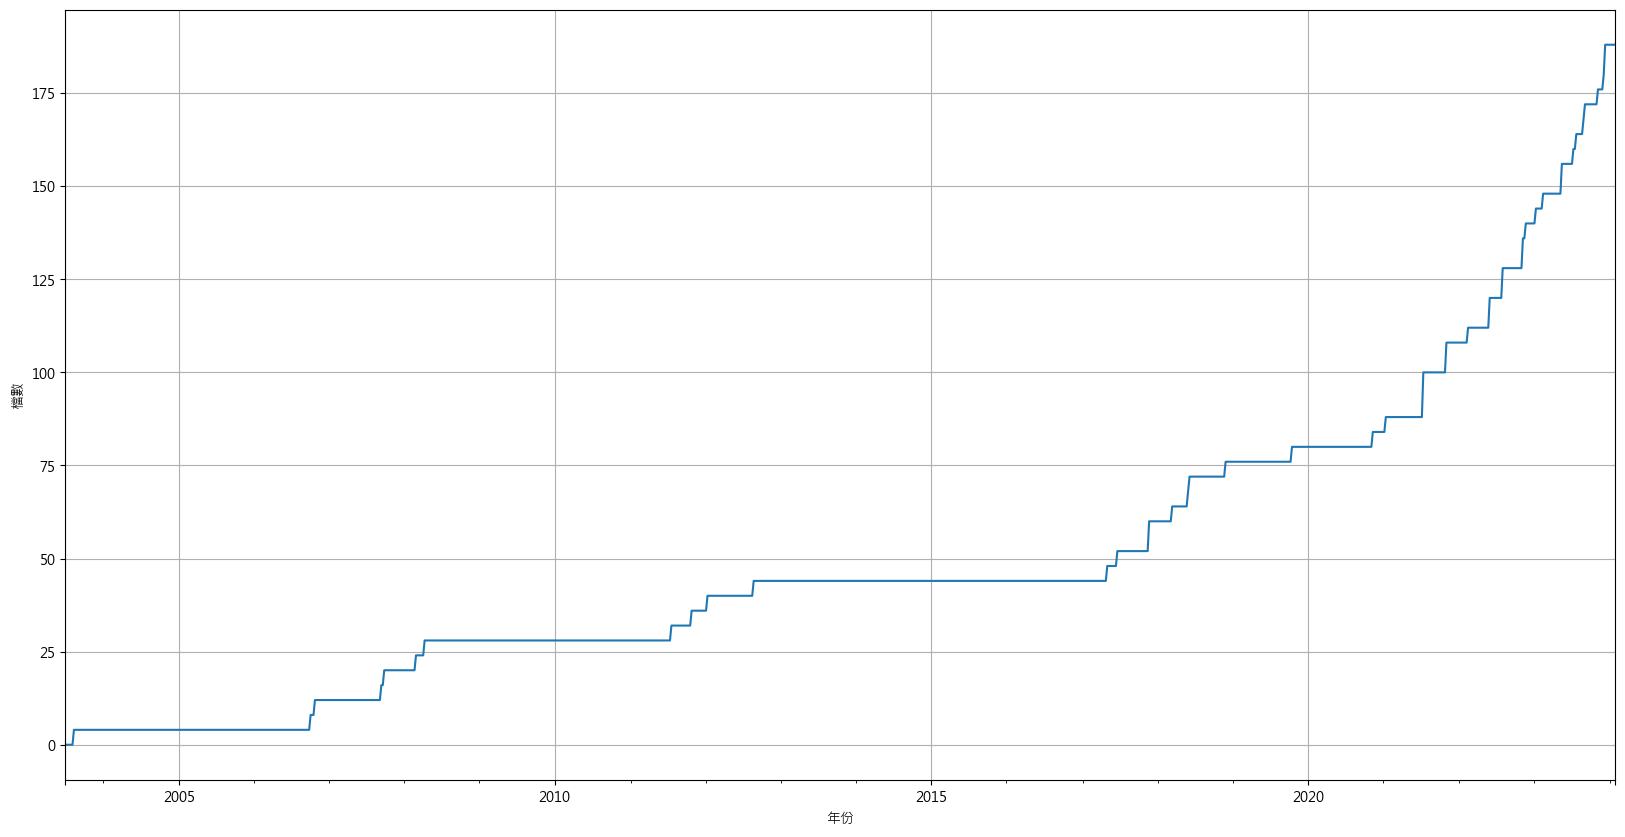

In [16]:
pz1 = pz.sort_index()
f = lambda x :float(x)
pz2 = pz1.applymap(f)
pz3 = pz2.sum(axis=1)
pz4 = pz3.groupby(pd.Grouper(freq='1W')).tail(1)
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
print(pz4.mean())
print(pz4.min())
print(pz4.max())
pz4.plot(figsize=(20, 10),grid = True)
plt.xlabel("年份")
plt.ylabel("檔數")

In [17]:
當週日期 = trr.index[-1]
前週日期 = trr.index[-2]

Text(0, 0.5, '報酬')

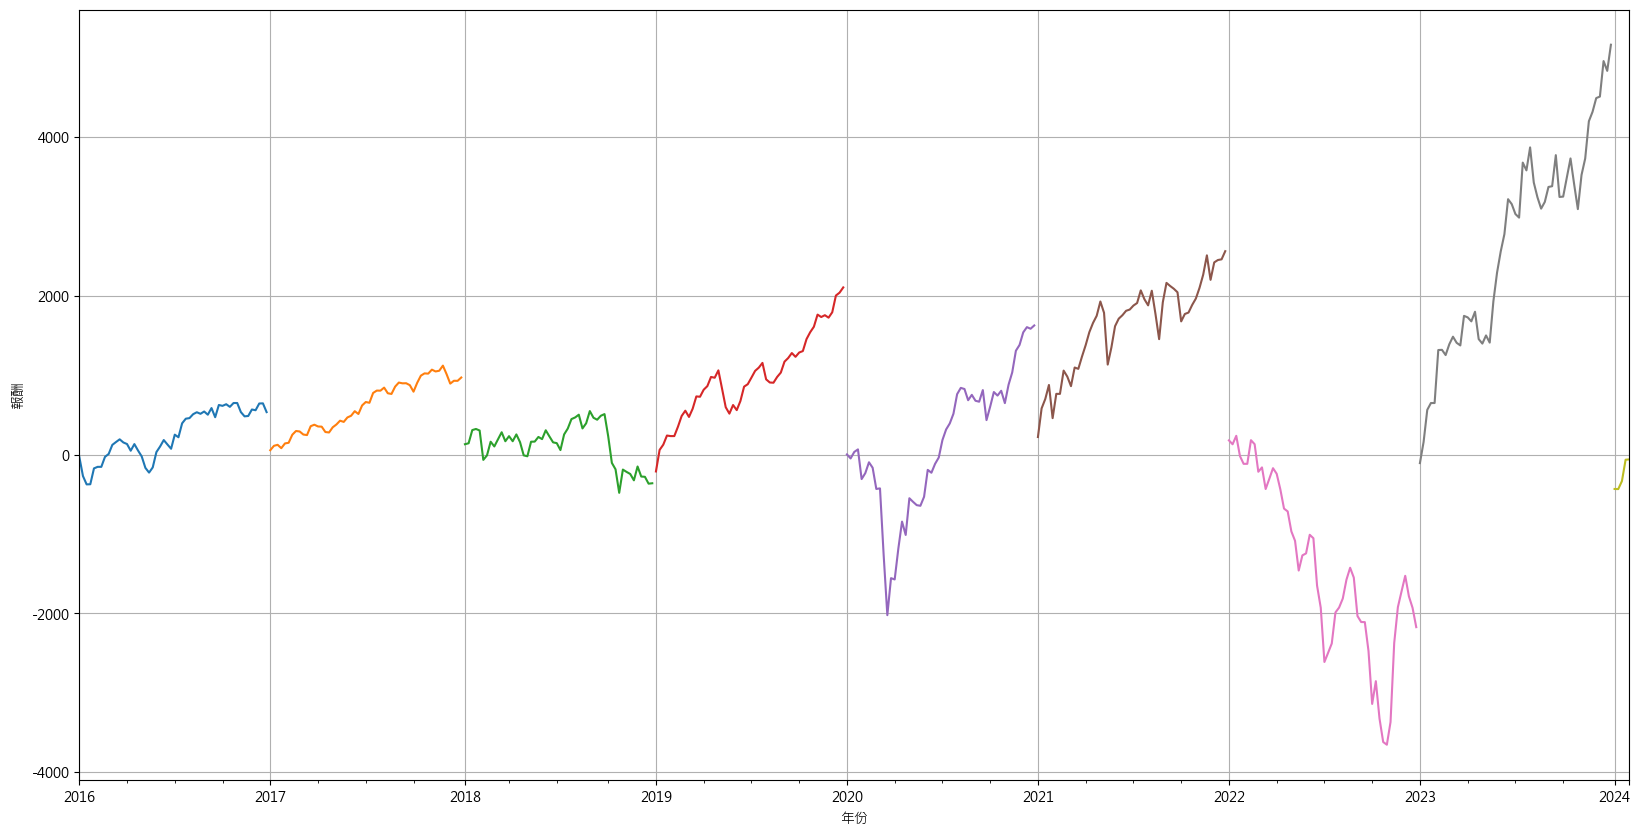

In [18]:
yl = ['2016','2017','2018','2019','2020','2021','2022','2023','2024']
for h in yl :
    trrt = (trr).groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = (trrt).plot(figsize=(20, 10),grid = True)
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")

Text(0, 0.5, '報酬')

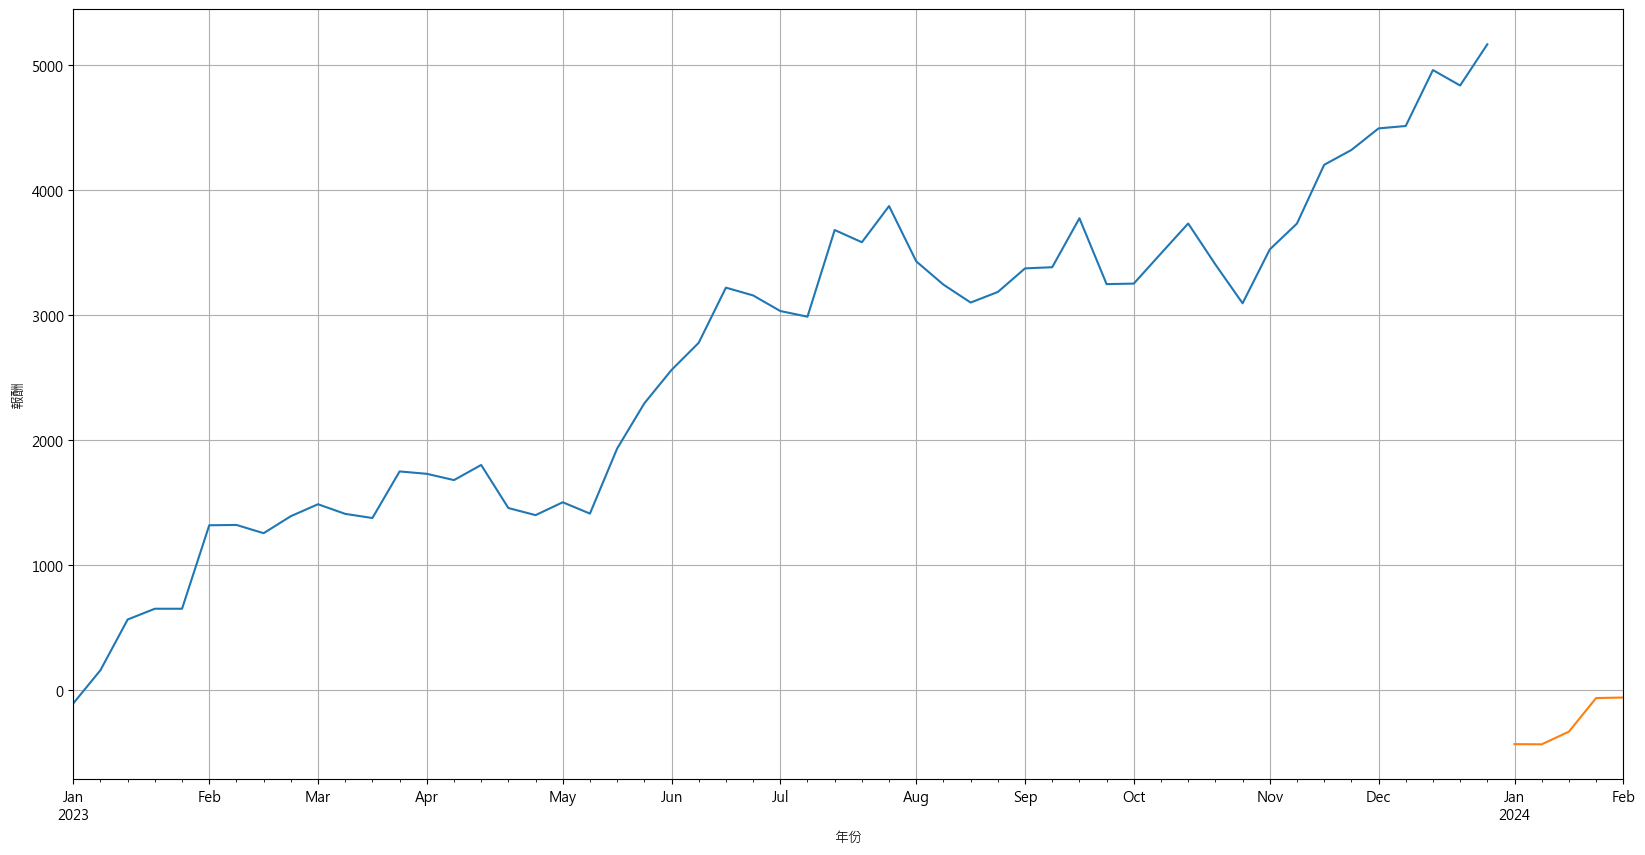

In [19]:
yl = ['2023','2024']
for h in yl :
    trrt = (trr).groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = (trrt).plot(figsize=(20, 10),grid = True)
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")

In [20]:
trrt

key_0
2024-01-07   -433.951398
2024-01-14   -435.492686
2024-01-21   -334.375749
2024-01-28    -65.457674
2024-02-04    -61.224362
Freq: W-SUN, dtype: float64